<a href="https://colab.research.google.com/github/bikash-bhoi/eva4/blob/master/Session%207/EVA4S7A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 bird plane   car  bird


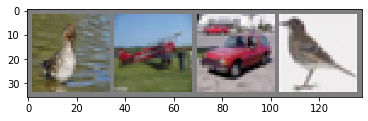

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block1= nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3,3), bias=False, padding=1, padding_mode='same'), #32 -> 32, 3 (in->out, RF)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), bias=False, padding=1), #32 -> 32, 5
            nn.BatchNorm2d(128),
            nn.ReLU(), 
        )
        self.shortcut1 = nn.Sequential(
                nn.Conv2d(3, 128, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(128)
        )
        self.trans_block1= nn.Sequential(
            nn.MaxPool2d(2,2),#32 -> 16, 6
            nn.Conv2d(128, 64, kernel_size=1, stride=1, bias=False)

        )
        self.conv_block2= nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), bias=False, padding=1), #16 -> 16, 10
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #Depthwise separable convolution
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, groups=128) , #16->16, 14
            #pointwise convolution
            nn.Conv2d(128, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.shortcut2 = nn.Sequential(
                nn.Conv2d(64, 256, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(256)
        )
        self.trans_block2= nn.Sequential(
            nn.MaxPool2d(2,2),#32 -> 16->8, 16
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1,1))
        )
        self.conv_block3= nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), bias=False, padding=1), #8 -> 8, 24
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1) , #8->8, 32
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.shortcut3 = nn.Sequential(
                nn.Conv2d(32, 128, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(128)
        )
        self.conv_block4 = nn.Sequential(
            #Dialated convolution
            nn.Conv2d(128, 512, kernel_size=(3,3), padding=1, bias=False,dilation=2) #8->6, 40
        )
        self.final_block= nn.Sequential(
            #GAP
            nn.AvgPool2d(kernel_size=6),  #6->1, 60
            nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1,1))
        )

    def forward(self, x):
        out1= self.conv_block1(x)
        out1 += self.shortcut1(x)    #add shortcut ResNet like
        out1= self.trans_block1(out1)
        out2= self.conv_block2(out1)
        out2 += self.shortcut2(out1) #add shortcut ResNet like
        out2= self.trans_block2(out2)
        out3= self.conv_block3(out2)
        out3 += self.shortcut3(out2) #add shortcut ResNet like
        x = self.conv_block4(out3)
        x= self.final_block(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)

cuda


In [6]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]             384
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           8,192
           Conv2d-11          [-1, 128, 16, 16]          73,728
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 69 %


In [0]:
from tqdm import tqdm

train_losses = []
test_losses_1 = []
train_acc = []
test_acc_1 = []
criterion = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_1.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_1.append(100. * correct / len(test_loader.dataset))

In [11]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = OneCycleLR(optimizer,max_lr=0.2,total_steps=20)

for epoch in range(1, 21):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)
    scheduler.step()

  0%|          | 0/12500 [00:00<?, ?it/s]

Epoch: 1 Learning_Rate [0.008000000000000007]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.8202915191650391 Batch_id=12499 Accuracy=44.22: 100%|██████████| 12500/12500 [02:19<00:00, 89.74it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


Test set: Average loss: 1.1671, Accuracy: 5883/10000 (58.83%)

Epoch: 2 Learning_Rate [0.026334368540005065]


Loss=2.1871044635772705 Batch_id=12499 Accuracy=37.15: 100%|██████████| 12500/12500 [02:23<00:00, 86.88it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


Test set: Average loss: 3.0926, Accuracy: 2758/10000 (27.58%)

Epoch: 3 Learning_Rate [0.07433436854000505]


  0%|          | 0/12500 [00:00<?, ?it/s]


Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

Epoch: 4 Learning_Rate [0.13366563145999494]


Loss=nan Batch_id=8868 Accuracy=10.00:  71%|███████   | 8861/12500 [01:43<00:42, 85.12it/s]

KeyboardInterrupt: ignored

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 47 %
Accuracy of  bird : 59 %
Accuracy of   cat : 25 %
Accuracy of  deer : 47 %
Accuracy of   dog : 60 %
Accuracy of  frog : 58 %
Accuracy of horse : 61 %
Accuracy of  ship : 64 %
Accuracy of truck : 61 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:

